In [1]:
"""
© 2023. Triad National Security, LLC. All rights reserved.
This program was produced under U.S. Government contract 89233218CNA000001 for Los Alamos
National Laboratory (LANL), which is operated by Triad National Security, LLC for the U.S.
Department of Energy/National Nuclear Security Administration. All rights in the program are.
reserved by Triad National Security, LLC, and the U.S. Department of Energy/National Nuclear
Security Administration. The Government is granted for itself and others acting on its behalf a
nonexclusive, paid-up, irrevocable worldwide license in this material to reproduce, prepare.
derivative works, distribute copies to the public, perform publicly and display publicly, and to permit.
others to do so.
"""

from numpy import (array, empty, zeros, linspace, arange, tile, where, maximum,
                   add, outer, sqrt, exp, log, cosh, tanh, pi as π)
from numpy.linalg import solve, inv, eig

%matplotlib inline
import matplotlib.pyplot as plt

from parameter_set import ParameterSet

# Reaction & diffusion in a pore

Mole balance  
<span>
    <a/> <img src="figures/PoreDiagram.png" width="600"/> </a>
</span>
.

\begin{equation}
c_{\mathrm{t}} V_{\mathrm{contr.}} \frac{\partial x_i}{\partial t} = A_{\mathrm{cross}} \left( N_i^l - N_i^{l + 1} \right) + A_{\mathrm{circ.}} r''_{\mathrm{rxn},i}
\end{equation}

Dividing by the volume and taking the limit as $\Delta z \rightarrow 0$:
\begin{equation}
c_{\mathrm{t}} \frac{\partial x_i}{\partial t} = \frac{\partial N_i}{\partial z}  + \frac{2}{r_{\mathrm{p}}} r''_{\mathrm{rxn},i}
\end{equation}

Of course, this governing equation requires a constitutive relation for the flux and a rate law for the  reactions.

Mixture-averaged Fickian diffusion (without resistance in the pores):
\begin{equation}
J_i = -c_{\mathrm{t}} D_{\mathrm{mix}, i} \frac{\partial x_i}{\partial z}
\end{equation}

Multi-component mass transfer (specifically the generalized Stefan-Maxwell equations with Knudsen resistance in the pores):
\begin{equation}
c_{\mathrm{t}} \frac{\partial x_i}{\partial z} = -\sum_{j=1}^{n_{\mathrm{spec.}}} \frac{x_j N_i - x_i N_j}{\mathscr{D}_{i, j}}
- \frac{N_i}{\mathscr{D}_{\mathrm{K}, i}}
\end{equation}

Both of these are supported by the mass-conservation bootstrap (everything that goes into the pore must come out). It implies that $N_j = J_j$ and that $\sum_j M_j N_j = 0$.

# Setup

In [2]:
PSS1 = type('ParameterSetSubclass1', (ParameterSet,), dict())
# Nominal parameter values:
θ = PSS1(# Thermodynamic properties:
         thermo=dict(R = 8.31446,  # gas constant [m^3 Pa / (K mol)] = [m^2 kg / (s^2 K mol)]
                     P = 2 * 1e5,  # pressure [Pa]
                     T = 228 + 273.15),  # temperature [K]
         # Chemical species properties:
         spec=dict(n_el = 4,  # number of elements (C, H, O, N)
                   n_spec = 6,  # number of chemical species (C2H4, O2, C2H4O, CO2, H2O, N2)
                   M = array([28, 32, 44, 44, 18, 28]),  # molar masses [g/mol]
                   ν_mol = array([[2, 4, 0, 0],
                                  [0, 0, 2, 0],
                                  [2, 4, 1, 0],
                                  [1, 0, 2, 0],
                                  [0, 2, 1, 0],
                                  [0, 0, 0, 2]]),  # molecular stoichiometry
                   V_mol = array([41.04, 16.3, 47.15, 26.7, 13.1, 18.5]),  # diffusion volumes
                   α = 1.013e-2),  # constant in the Fuller equation [?]
         # Chemical reaction properties & parameters:
         rxn=dict(n_rxn = 2,  # number of reactions
                  # Reaction stoichiometry [-]
                  ν_rxn = array([[-1.0,-1.0],  # ethylene
                                 [-0.5,-3.0],  # oxygen
                                 [ 1.0, 0.0],  # ethylene oxide
                                 [ 0.0, 2.0],  # carbon dioxide
                                 [ 0.0, 2.0],  # water
                                 [ 0.0, 0.0]]),# nitrogen
                  # Nominal reaction rate parameters
                  # # Klugherz's rate law:
                  # rate_params=dict(a_cat0 = 0.5,  # cat. spec. surface area in expt. [m^2 / g]
                  #                  r01 = (6 + 7) / 2 * 1e-6,  # eo [mol. rxn. / (min. g-cat.)]
                  #                  rKo1 = 6.32,
                  #                  Ke1 = 0.053,
                  #                  Ko1 = 0.0199,
                  #                  Cp1 = 0.0106,
                  #                  r02 = (4 + 6) / 2 * 1e-6,  # CO2 [mol. rxn. / (min. g-cat.)]
                  #                  rKo2 = 3.57,
                  #                  Ke2 = 0.103,
                  #                  Ko2 = 0.0390,
                  #                  Cp2 = 0.0080)),
                  # Alternate rate law:
                  rate_params=dict(Ke = 2.3,
                                   Ko = 6.5,
                                   Cp = 0.0,
                                   n1e = 0.749,
                                   n1o = 2.771,
                                   n2e = 0.724,
                                   n2o = 2.897,
                                   keo = 5.420e-6,
                                   kc = 5.292e-6)),
        cat=dict(D_pore = 0.15e-6,  # diameter of the pores [m]
                 L_pore = 1.0e-3))  # characteristic pore length [m]

# Thermodynamic model (EOS) for molar concentration:
def thermo_c_ideal(R, P, T):
    """Calculate the concentration using the ideal-gas law EOS [mol/m^3]."""
    return P / (R * T)  # molar concentration [mol/m^3]

# Chemical reaction-rate model:
def rxn_rate_Klugherz(x, P, T, a_cat, r01, rKo1, Ke1, Ko1, Cp1, r02, rKo2, Ke2, Ko2, Cp2):
    """
    Calculate the reaction rates [mol-rxn. / (s m^2-cat.)] from reactant pressures [bar]
    using the rate law provided in Klugherz & Harriott (1971).
    """
    # Convert from pressure [Pa] & mole fractions [-] to partial pressures [atm].
    Pe = x[0] * P / 1.01325e5
    Po = x[1] * P / 1.01325e5
    r1 = r01 * Pe * Po**2 / (((Cp1 + Ke1 * Pe + Ko1 * Po) * (1 + rKo1 * sqrt(Po)))**2)
    r2 = r02 * Pe * Po**2 / (((Cp2 + Ke2 * Pe + Ko2 * Po) * (1 + rKo2 * sqrt(Po)))**2)
    rates = array([r1, r2]) / (60 * a_cat)  # unit conversion to [mol. rxn. / (s m^2-cat.)]
    return rates

def rxn_rate_alt(x, P, T, Ke, Ko, Cp, n1e, n1o, n2e, n2o, keo, kc):
    """
    Calculate the reaction rates [mol-rxn. / (s m^2-cat.)] from reactant pressures [bar]
    using an alternative rate law (all sites available for adsorption, atomic-oxygen adsorption,
    Eley-Rideal for eth. ox., simple-Langmuir for CO2, variable-order rxns.).
    """
    # Convert from pressure [Pa] & mole fractions [-] to partial pressures [bar].
    Pe = x[0] * P * 1e-5
    Po = x[1] * P * 1e-5
    F = 1 + Ke * Pe + sqrt(Ko * Po) + Cp
    θe = Pe
    θo = sqrt(Ko * Po) / F
    r1 = keo * θe**n1e * θo**n1o
    θe = Ke * Pe / F
    θo = sqrt(Ko * Po) / F
    r2 = kc * θe**n2e * θo**n2o
    rates = array([r1, r2])
    return rates

def spec_rates(x, P, T, ν_rxn, rate_law, rate_params):
    """
    Calculate the species production rates [mol / (s m^2-cat.)] from reactant pressures [bar].
    """
    return ν_rxn @ rate_law(x, P, T, *rate_params)

def diff_bin(P, T, M, α, V_mol):
    """Calculate the species binary diffusion coefficients."""
    Dij = (α * T**1.75 * sqrt(add.outer(M, M) / outer(M, M)) /
           (P * add.outer(V_mol**(1 / 3), V_mol**(1 / 3))**2))  # Fuller correlation
    return Dij

def diff_mix(Dij, x):
    """Calculate the species mixture-averaged diffusion coefficients."""
    Dmix = (1 - x) / (x / Dij).sum(axis=1)  # Wilke model (ignores pore diffusion)
    return Dmix

def diff_knudsen(T, D_pore, R, M):
    """Calculate the Knudsen pore diffusion coefficients."""
    Dk = (D_pore / 3) * sqrt((8 * R * T) / (π * M))
    return Dk

def diff_mix_wpores(Dij, Dk, x):
    """
    Calculate the species mixture-averaged diffusion coefficients accounting for pore diffusion.
    """
    Dmix = (1 - x) / ((x / Dij).sum(axis=1) + 1 / Dk)
    return Dmix

# Analytical: constant rxns.

[-4.78726787e-07 -7.56139075e-07  2.72016515e-07  4.13420545e-07
  4.13420545e-07  0.00000000e+00]
[-0.15965362 -0.29882373  0.10199838  0.15368681  0.09824878  0.        ]


/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_47787/765827703.py:13: RuntimeWarning: divide by zero encountered in true_divide
  z_crit = where(-M > x_surf, θ.L_pore * (1 - sqrt((x_surf + M) / M)), θ.L_pore).min()


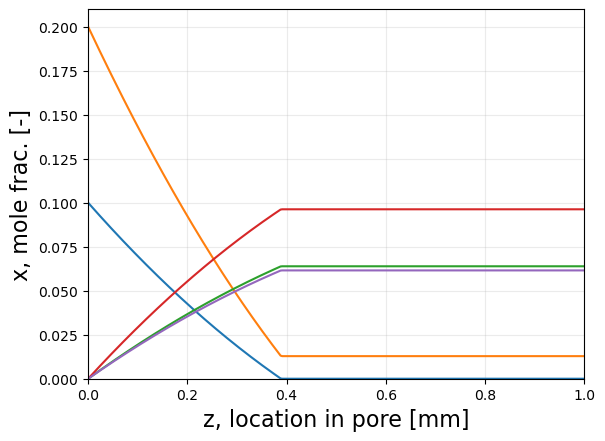

In [3]:
Ct = thermo_c_ideal(θ.R, θ.P, θ.T)
ns, n_rxn = int(θ.n_spec), int(θ.n_rxn)
ν_rxn = θ.ν_rxn.reshape((ns, n_rxn))
Dij = diff_bin(θ.P, θ.T, θ.M, θ.α, θ.V_mol)
Dk = diff_knudsen(θ.T, θ.D_pore, θ.R, θ.M)
x_surf = array([0.1, 0.2, 0.0, 0.0, 0.0, 0.7])
Dmix = diff_mix_wpores(Dij, Dk, x_surf)

rate = spec_rates(x_surf, θ.P, θ.T, ν_rxn, rxn_rate_alt, θ.rate_params)
print(rate)
M = θ.L_pore**2 * rate / (θ.D_pore / 2 * Ct * Dmix)
print(M)
z_crit = where(-M > x_surf, θ.L_pore * (1 - sqrt((x_surf + M) / M)), θ.L_pore).min()
nz = 300
x = empty((ns, nz))
z = linspace(0, θ.L_pore, nz)
for i in range(ns):
    x[i] = where(z < z_crit, x_surf[i] + M[i] * (2 - z      / θ.L_pore) * (z      / θ.L_pore),
                             x_surf[i] + M[i] * (2 - z_crit / θ.L_pore) * (z_crit / θ.L_pore))

plt.plot(z * 1e3, x[:-1].T)
plt.grid(True, alpha=0.25)
plt.xlim(0, θ.L_pore * 1e3)
plt.ylim(0, None)
plt.xlabel('z, location in pore [mm]', fontsize=16)
plt.ylabel('x, mole frac. [-]', fontsize=16) ;

# Analytical: linearized single-rxn.
The linearization caries the requirement that when $x=0$ then $r=0$.

0.5044332415781203


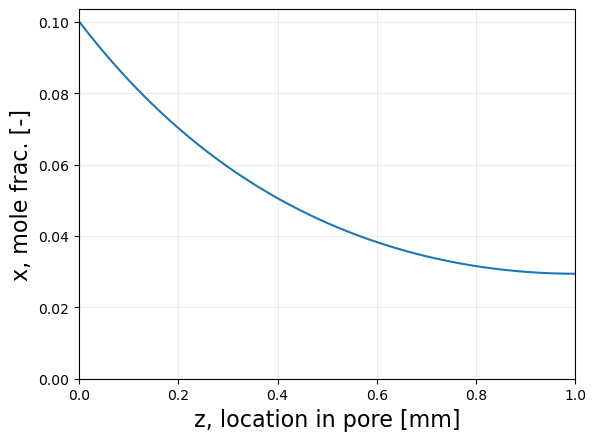

In [4]:
Ct = thermo_c_ideal(θ.R, θ.P, θ.T)
ns, n_rxn = int(θ.n_spec), int(θ.n_rxn)
ν_rxn = θ.ν_rxn.reshape((ns, n_rxn))
Dij = diff_bin(θ.P, θ.T, θ.M, θ.α, θ.V_mol)
x_surf = array([0.1, 0.2, 0.0, 0.0, 0.0, 0.7])
# Dmix = diff_mix(Dij, x_surf)
Dk = diff_knudsen(θ.T, θ.D_pore, θ.R, θ.M)
Dmix = diff_mix_wpores(Dij, Dk, x_surf)

rate = spec_rates(x_surf, θ.P, θ.T, ν_rxn, rxn_rate_alt, θ.rate_params)
ke_lin = -rate[0] / (Ct * x_surf[0])  # rate coefficient linearized in C2H4
λ = sqrt((2 * ke_lin) / (Dmix[2] * θ.D_pore / 2))
nz = 300
z = linspace(0, θ.L_pore, nz)
x = x_surf[0] * cosh(λ * (θ.L_pore - z)) / cosh(λ * θ.L_pore)
ε_eff = tanh(λ * θ.L_pore) / (λ * θ.L_pore)
N0 = ε_eff * rate  # mol / (s m^2-cat)

print(ε_eff)
plt.plot(z * 1e3, x)
plt.grid(True, alpha=0.25)
plt.xlim(0, θ.L_pore * 1e3)
plt.ylim(0, None)
plt.xlabel('z, location in pore [mm]', fontsize=16)
plt.ylabel('x, mole frac. [-]', fontsize=16) ;

# Time evolution (explicit)

In [5]:
Ct = thermo_c_ideal(θ.R, θ.P, θ.T)
ns, n_rxn = int(θ.n_spec), int(θ.n_rxn)
ν_rxn = θ.ν_rxn.reshape((ns, n_rxn))
Dij = diff_bin(θ.P, θ.T, θ.M, θ.α, θ.V_mol)
Dk = diff_knudsen(θ.T, θ.D_pore, θ.R, θ.M)
x_surf = array([0.1, 0.2, 0.0, 0.0, 0.0, 0.7])

nz = 25  # number of discretizations across z
z, Δz = linspace(0, θ.L_pore, nz, retstep=True)
t_fin = 3.0
nt = 20_000
t, Δt = linspace(0, t_fin, nt, retstep=True)
x = empty((nt + 1, nz, ns))
x[0] = x_surf
for i in range(nt):
    # print(f'i = {i}')

    # # Mixture-averaged Fickian diffusion (no Knudsen):
    # N = empty((nz, ns))
    # x_mid = x_surf
    # grad_x = (x[i, 0] - x_surf) / (Δz / 2)
    # Dmix = (1 - x_mid) / ((x_mid / Dij).sum(axis=1))# - x_mid / Dij[arange(ns), arange(ns)])
    # N[0] = -Dmix * grad_x
    # N[0, -1] = -N[0, :-1].sum()
    # for l in range(1, nz):
    #     x_mid = (x[i, l - 1] + x[i, l]) / 2
    #     grad_x = (x[i, l] - x[i, l - 1]) / Δz
    #     Dmix = (1 - x_mid) / ((x_mid / Dij).sum(axis=1))# - x_mid / Dij[arange(ns), arange(ns)])
    #     N[l] = -Dmix * grad_x
    #     N[l, -1] = -N[l, :-1].sum()

    # Generalized Stefan-Maxwell diffusion (w/ Knudsen):
    N = empty((nz, ns))
    x_mid = x_surf
    grad_x = (x[i, 0] - x_surf) / (Δz / 2)
    A = x_mid.reshape((ns, 1)) / Dij
    A[arange(ns), arange(ns)] = A[arange(ns), arange(ns)] - ((1 / Dij) @ x_mid + 1 / Dk)
    b = Ct * grad_x
    A[-1] = θ.M
    b[-1] = 0
    N[0] = solve(A, b)
    # print(f'   N[0] = {N[0]}')
    for l in range(1, nz):
        x_mid = (x[i, l - 1] + x[i, l]) / 2
        grad_x = (x[i, l] - x[i, l - 1]) / Δz
        A = x_mid.reshape((ns, 1)) / Dij
        A[arange(ns), arange(ns)] = A[arange(ns), arange(ns)] - ((1 / Dij) @ x_mid + 1 / Dk)
        b = Ct * grad_x
        A[-1] = θ.M
        b[-1] = 0
        N[l] = solve(A, b)

    r = empty((nz, ns))
    for l in range(nz):
        r[l] = spec_rates(x[i, l], θ.P, θ.T, ν_rxn, rxn_rate_alt, θ.rate_params)

    x[i + 1, :-1] = x[i, :-1] + Δt * ((N[:-1] - N[1:]) / Δz + 4 * r[:-1] / θ.D_pore) / Ct
    x[i + 1,  -1] = x[i,  -1] + Δt * ((N[ -1] -     0) / Δz + 4 * r[ -1] / θ.D_pore) / Ct
    # print(f'   x[0] = {x[i + 1, 0]}')
x_last = x[nt - 1]
N_last = N

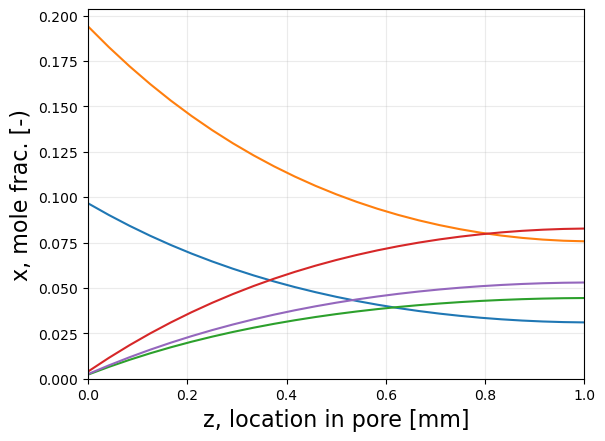

In [6]:
plt.plot(z * 1e3, x_last[:, :-1])
plt.grid(True, alpha=0.25)
plt.xlim(0, θ.L_pore * 1e3)
plt.ylim(0, None)
plt.xlabel('z, location in pore [mm]', fontsize=16)
plt.ylabel('x, mole frac. [-)', fontsize=16) ;

[ 7.34488061e-03  1.22876630e-02 -3.89443037e-03 -6.88420352e-03
 -6.89491919e-03 -1.76226982e-05]


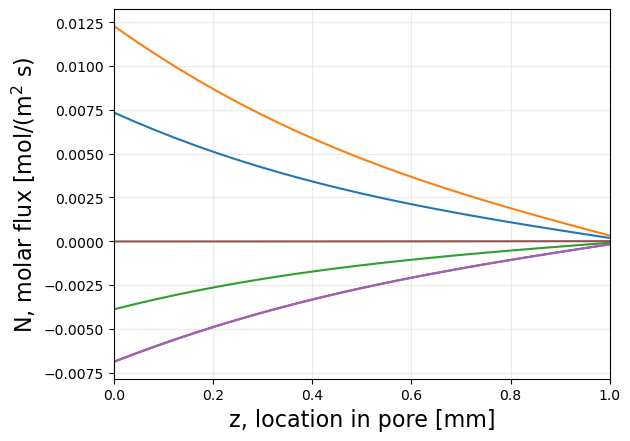

In [7]:
plt.plot(z * 1e3, N)
plt.grid(True, alpha=0.25)
plt.xlim(0, θ.L_pore * 1e3)
plt.xlabel('z, location in pore [mm]', fontsize=16)
plt.ylabel('N, molar flux [mol/(m$^2$ s)', fontsize=16)
print(N[0])

In [8]:
# plt.plot(t, x[:, -1, 3])
# plt.grid(True, alpha=0.25)
# plt.xlim(0, t[-1])
# plt.ylim(0, None)
# plt.xlabel('time [s]', fontsize=16)
# plt.ylabel('$x_{C2H4O}$ at the pore base [-]', fontsize=16) ;

# Steady state (implicit)

In [9]:
# print(x_last)
# print(N_last)

In [10]:
nz = 15  # number of discretizations across z
z, Δz = linspace(0, θ.L_pore, nz, retstep=True)
def residual(X):
    N = X[:(nz * ns)].reshape((nz, ns))  # molar fluxes [mol/(m^2 s)]
    x = X[-(nz * ns):].reshape((nz, ns))  # mole fractions [-]

    r = empty((nz, ns))
    for l in range(nz):
        r[l] = spec_rates(x[l], θ.P, θ.T, ν_rxn, rxn_rate_alt, θ.rate_params)  # reaction rates [mol / (s m^2)]

    resid = empty((2, nz, ns))
    # Mole balance:
    resid[0, :-1] = (N[:-1] - N[1:]) / Δz  + 2 * r[:-1] / (θ.D_pore / 2)
    resid[0, -1]  = (N[-1]  -     0) / Δz  + 2 * r[-1]  / (θ.D_pore / 2)
    # Constitutive relations for diffusion (generalized Stefan-Maxwell):
    x_mid = x_surf
    grad_x = (x[0] - x_surf) / (Δz / 2)
    resid[1, 0] = Ct * grad_x + ((outer(N[0], x_mid) - outer(x_mid, N[0])) / Dij).sum(axis=1) + N[0] / Dk
    for l in range(1, nz):
        x_mid = (x[l - 1] + x[l]) / 2
        grad_x = (x[l] - x[l - 1]) / Δz
        resid[1, l] = Ct * grad_x + ((outer(N[l], x_mid) - outer(x_mid, N[l])) / Dij).sum(axis=1) + N[l] / Dk
    resid[1, :, -1] = (N * M).sum(axis=1)
    # resid[1] *= 1e9
    return resid.reshape(-1)
# N_guess = zeros((nz, ns))
# x_guess = tile(x_surf, (nz, 1))
x_guess = x_last
N_guess = N_last
X_guess = array([N_guess, x_guess]).reshape(-1)
test = residual(X_guess).reshape((2, nz, ns))
# print(test)

In [11]:
# from scipy.optimize import fsolve
# X, info, ier, message = fsolve(residual, X_guess, full_output=True)
# print(message)
# print(X)
# N = X[:(nz * ns)].reshape((nz, ns))  # molar fluxes [mol/(m^2 s)]
# x = X[-(nz * ns):].reshape((nz, ns))  # mole fractions [-]
# plt.plot(z, x[:, 0])

I cannot get this to work! It seems to be too much for fsolve.

# More robust & faster dynamic solver
There are two problems using the [explicit dynamic solver above](#Time-evolution-(explicit)) to obtain a steady-state solution — first, it has harsh demands of small time steps for stability; and second; with small time steps it is slow. In order to solve the pore reaction/diffusion problem robustly and efficiently I have considered several alternatives:
1. Continuation method or other more robust nonlinear solver — the problem, here, is that the methods in this category with which I am familiar all require gradient information. The gradients of the governing equation as written are not an issue, but requiring gradients for each of the sub-models and particularly for each reaction model does not seem like a reasonable demand.
2. Shooting method — initially this seemed attractive, until considering that attempts almost always result in unphysical profiles (before convergence). With complicated models containing square roots and requiring variables to sum to unity it is asking for trouble. Beyond that, each species has a flux at the pore mouth that would need to be determined — so this still would required a multi-variable nonlinear solve. From the big picture, this still is a boundary value problem with eigenvalues going both ways — best to solve it with a numerical method that behaves similarly.
3. AMR for the explicit dynamic solver — on one hand this is a poor-man's continuation method, the stability constraint for diffusion is bad, and AMR has a reputation for bogging down progress. On the other hand, it avoids the requirements of Newton's method, it allows propagation of information in both directions, it can provide significant speed up, and in one dimension with refinement exclusively extending from one edge of the domain & in the context of finite volume the AMR algorithm may actually be quite simple.

Stability criterion:  
$\frac{D \Delta t}{\Delta x^2} < 1/2 \quad \Rightarrow \quad \Delta t < \frac{\Delta x^2}{2 D}$  
Convergence criterion:  
$\delta < \varepsilon_{\mathrm{discr.}}$ where $\delta = \frac{(y_1 - y_2)^2}{y_0 - 2 y_1 + y_2}$  
Convergence in spatial resolution (for a second-order central difference):  
$\varepsilon_{\mathrm{discr.}} = \mathcal{O} \left( \frac{\Delta z^2 f^{(4)}}{24} \right)$

In [12]:
def resid(y0, y1, y2):
    """Use three equally spaced points to determine the residual."""
    return (y1 - y2)**2 / (y0 - 2 * y1 + y2)

In [13]:
Ct = thermo_c_ideal(θ.R, θ.P, θ.T)
ns, n_rxn = int(θ.n_spec), int(θ.n_rxn)
ν_rxn = θ.ν_rxn.reshape((ns, n_rxn))
Dij = diff_bin(θ.P, θ.T, θ.M, θ.α, θ.V_mol)
Dk = diff_knudsen(θ.T, θ.D_pore, θ.R, θ.M)
x_surf = array([0.1, 0.2, 0, 0, 0, 0.7])

nz = 10  # number of discretizations across z
z, Δz = linspace(0, θ.L_pore, nz, retstep=True)
nt = 20_000
t = empty(nt + 1)
t[0] = 0
x = empty((nt + 1, nz, ns))

# Initial condition (analytical, constant rxn.)
Dmix = diff_mix_wpores(Dij, Dk, x_surf)
rate = spec_rates(x_surf, θ.P, θ.T, ν_rxn, rxn_rate_alt, θ.rate_params)
M = θ.L_pore**2 * rate / (θ.D_pore / 2 * Ct * Dmix)
z_crit = where(-M > x_surf, θ.L_pore * (1 - sqrt((x_surf + M) / M)), θ.L_pore).min()
for i in range(ns):
    x[0, :, i] = where(z < z_crit, x_surf[i] + M[i] * (2 - z      / θ.L_pore) * (z      / θ.L_pore),
                                   x_surf[i] + M[i] * (2 - z_crit / θ.L_pore) * (z_crit / θ.L_pore))
x[0] = maximum(x[0], 1e-8)  # rxn. rate law may not work with x=0

Δt_large = float('inf')
for i in range(nt):
    # Generalized Stefan-Maxwell diffusion (w/ Knudsen):
    N = empty((nz, ns))
    Δt = Δt_large
    for l in range(nz):
        if l == 0:
            x_mid = x_surf
            grad_x = (x[i, 0] - x_surf) / (Δz / 2)
        else:
            x_mid = (x[i, l - 1] + x[i, l]) / 2
            grad_x = (x[i, l] - x[i, l - 1]) / Δz
        A = x_mid.reshape((ns, 1)) / Dij
        A[arange(ns), arange(ns)] = A[arange(ns), arange(ns)] - ((1 / Dij) @ x_mid + 1 / Dk)
        b = Ct * grad_x
        A[-1] = θ.M
        b[-1] = 0
        D_Fick = inv(A)
        N[l] = D_Fick @ b
        Δt = min(Δt, 0.05 * Δz**2 / (2 * Ct * D_Fick[:-1, :-1].max()))

    r = empty((nz, ns))
    for l in range(nz):
        r[l] = spec_rates(x[i, l], θ.P, θ.T, ν_rxn, rxn_rate_alt, θ.rate_params)

    t[i + 1] = t[i] + Δt
    x[i + 1, :-1] = x[i, :-1] + Δt * ((N[:-1] - N[1:]) / Δz + 4 * r[:-1] / θ.D_pore) / Ct
    x[i + 1,  -1] = x[i,  -1] + Δt * ((N[ -1] -     0) / Δz + 4 * r[ -1] / θ.D_pore) / Ct
    if i >= 1:
        res = resid(x[i + 1], x[i], x[i - 1])
        if abs(res).max() <= 1e-4:
            i_fin = i
            print(i_fin)
            break

x_last = x[i_fin - 1]
N_last = N

/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_47787/2842326983.py:19: RuntimeWarning: divide by zero encountered in true_divide
  z_crit = where(-M > x_surf, θ.L_pore * (1 - sqrt((x_surf + M) / M)), θ.L_pore).min()
/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_47787/88207659.py:3: RuntimeWarning: invalid value encountered in true_divide
  return (y1 - y2)**2 / (y0 - 2 * y1 + y2)


875


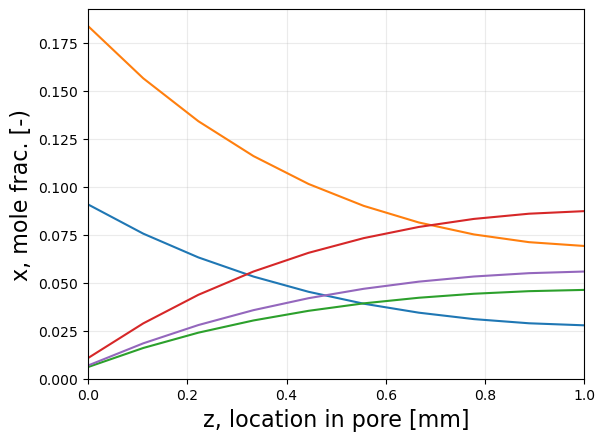

In [14]:
plt.plot(z * 1e3, x_last[:, :-1])
plt.grid(True, alpha=0.25)
plt.xlim(0, θ.L_pore * 1e3)
plt.ylim(0, None)
plt.xlabel('z, location in pore [mm]', fontsize=16)
plt.ylabel('x, mole frac. [-)', fontsize=16) ;

[ 7.39551704e-03  1.24198849e-02 -3.90835793e-03 -6.97320216e-03
 -6.97631622e-03 -5.30212514e-06]


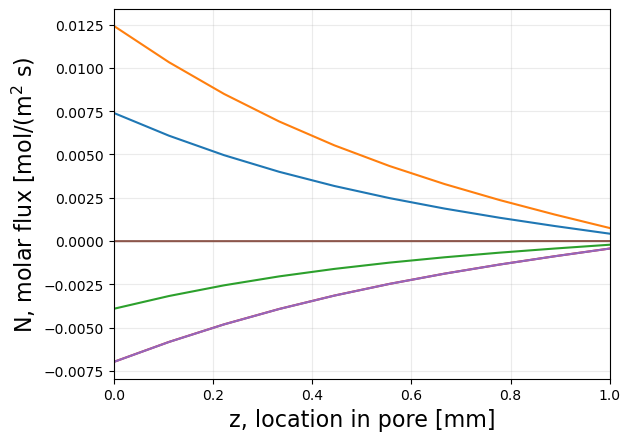

In [15]:
plt.plot(z * 1e3, N)
plt.grid(True, alpha=0.25)
plt.xlim(0, θ.L_pore * 1e3)
plt.xlabel('z, location in pore [mm]', fontsize=16)
plt.ylabel('N, molar flux [mol/(m$^2$ s)', fontsize=16)
print(N[0])

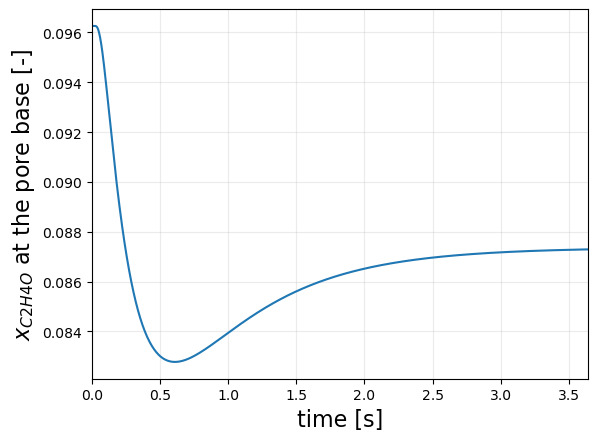

In [16]:
plt.plot(t[:i_fin], x[:i_fin, -1, 3])
plt.grid(True, alpha=0.25)
plt.xlim(0, t[i_fin])
# plt.ylim(0, None)
plt.xlabel('time [s]', fontsize=16)
plt.ylabel('$x_{C2H4O}$ at the pore base [-]', fontsize=16) ;

# Geometry & Catalyst specifics

In [17]:
# Reactor geometry:
D_tube = 3.912e-2  # tube diameters [m]
L_tube = 12.8  # tube lengths [m]
n_tubes = 2781  # number of tubes [-]
V_rxr = π * (D_tube / 2)**2 * L_tube * n_tubes

# Catalyst properties:
ρ_cat = 881  # catalyst density [kg/m^3]
m_cat = 9431  # catalyst total mass [kg]
A_cat = 4396e3  # total catalyst surface area [m^2]
V_cat = m_cat / ρ_cat  # total catalyst volume [m^3]
ε_void = 1 - V_cat / V_rxr  # as-packed void fraction (gaps-between pellets) [-]
print(f'packing void frac. {ε_void}')
a_cat = A_cat / m_cat  # catalyst specific surface area [m^2/kg]
print(f'cat. spec. surf. area: {a_cat : .3f} m^2/kg')
ρ_Al2O3 = 3.97e3  # solid density of alumina [kg/m^3]
v_pores = 1 / ρ_cat - 1 / ρ_Al2O3  # specific volume of catalyst pores [m^3/kg]
D_pore = 4e-6  # characteristic pore diameter [m]
L_pore = 1e-3  # characteristic pore length [m]
print(f'No. of pores per kg: {v_pores / (L_pore * π * (D_pore / 2)**2) : .2g}')

L_pellet = 5e-3  # pellet length [m]
Do_pellet = 5e-3  # pellet outer diameter [m]
Di_pellet = 2e-3  # pellet inner diameter [m]
V_pellet = π * ((Do_pellet / 2)**2 - (Di_pellet / 2)**2) * L_pellet  # volume of one pellet [m^3]
A_pellet = π * (Do_pellet + Di_pellet) * L_pellet  # outer (geometric) area of a pellet [m^2]
a_film = A_pellet / (ρ_cat * V_pellet)  # specific area (outer/geometric) of the catalyst [m^2 / kg]
print(f'film spec. surf. area {a_film : .3f} m^2/kg')

packing void frac. 0.7498023050071658
cat. spec. surf. area:  466.122 m^2/kg
No. of pores per kg:  7e+10
film spec. surf. area  1.513 m^2/kg


In [18]:
π * (D_tube / 2)**2 * L_pellet * (1 - ε_void) / V_pellet

18.233149874097215

In [19]:
n_pores = v_pores / (L_pore * π * (D_pore / 2)**2)
π * D_pore * L_pore * n_pores

883.1846110299437

In [20]:
print(28  + 3 * 32)
print(2 * 44 + 2 * 18)

124
124
